# Aujourd'hui on se fait rouler par les mecs de l'ENS


https://challengedata.ens.fr/en/challenge/39/prediction_of_transaction_claims_status.html


Ici, c'est le notebook dédié à la créations de stats. Donc il y a les SELLERS, et les PRODUCT TYPES qui y passent actuellement.

Il aurait pu aller dans le Notebook 2, mais comme c'est assez velu, j'ai décidé de le mettre à part. Je préfère garder le 2 pour du feature simple/eco, lalala.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

#misc libraries
import time
import random as rnd
import os, gc

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.22.0
matplotlib version: 2.1.2
NumPy version: 1.12.1
SciPy version: 1.0.0
IPython version: 6.2.1
scikit-learn version: 0.19.1
seaborn version: 0.8.1
-------------------------


Moi j'ai ça:

Python version: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]

pandas version: 0.22.0

matplotlib version: 2.1.2

NumPy version: 1.12.1

SciPy version: 1.0.0

IPython version: 6.2.1

scikit-learn version: 0.19.1

seaborn version: 0.8.1


In [2]:
# Run "! pip install jyquickhelper" dans une cellule si ca ne marche pas la commande suivante
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Chargement des données

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

def load_data(file,data_path=DATA_PROCESSED, sep=','):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep)

train_df = load_data(file = "train.csv", sep=';');
test_df = load_data(file = "test.csv", sep=';');


## Analyse des types de données

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
SHIPPING_MODE                100000 non-null object
SHIPPING_PRICE               100000 non-null int64
WARRANTIES_FLG               100000 non-null bool
WARRANTIES_PRICE             100000 non-null int64
CARD_PAYMENT                 100000 non-null int64
COUPON_PAYMENT               100000 non-null int64
RSP_PAYMENT                  100000 non-null int64
WALLET_PAYMENT               100000 non-null int64
PRICECLUB_STATUS             100000 non-null int64
REGISTRATION_DATE            100000 non-null int64
PURCHASE_COUNT               100000 non-null int64
BUYER_BIRTHDAY_DATE          100000 non-null float64
BUYER_DEPARTMENT             100000 non-null int64
BUYING_DATE                  100000 non-null int64
SELLER_SCORE_COUNT           100000 non-null int64
SELLER_SCORE_AVERAGE         100000 non-null float64
SELLER_COUNTRY               100000 non-null object
SELLER_DEPARTMENT 

## Plan d'action:

Idées de features engineering:
1. Trouver les ID des SELLERS
2. Trouver des stats par produits

## Création d'un ID par vendeur

Objectif = créer une base de données vendeur

In [6]:
import hashlib
def idSellCreator(row):
        return hashlib.md5(
            (str(row["SELLER_COUNTRY"])+
             str(row["SELLER_DEPARTMENT"])+
             str(row["SELLER_SCORE_AVERAGE"])+
             str(row['SELLER_SCORE_COUNT'])
            ).encode()
        ).hexdigest()

In [7]:
train_df['SELLER_ID'] = train_df.apply(idSellCreator, axis=1)
test_df['SELLER_ID'] = test_df.apply(idSellCreator, axis=1)

In [8]:
len(train_df['SELLER_ID'].append(test_df['SELLER_ID'], ignore_index=True).unique())

1691

On a 1691 identifiants uniques

In [9]:
print("Nombre d'ID sellers dans le train : {}\nNombre d'ID sellers dans le test : {}".format(
    len(train_df['SELLER_ID'].unique()),
    len(test_df['SELLER_ID'].unique()))
     )

Nombre d'ID sellers dans le train : 1563
Nombre d'ID sellers dans le test : 1568


## Stat' par vendeur

Maintenant qu'on a réussi à retrouver les différents vendeurs, faut utiliser cette information

#### Is Claim

Attention, c'est un peu dangereux d'utiliser la target variable pour faire du feature engineering.

Mais ici, je veux créer des "cartes d'identité" par vendeur et acheteur, pour reperer les bad guys. Donc je dois connaitre le taux de rejet de chacun. Ce que je vais faire plus tard.

In [10]:
# Fonction qui prend une ligne de la BDD en entrée, et dit "Si c'est - alors on renvoit 0, sinon 1
def b(row):
        return 0 if row['CLAIM_TYPE'] == '-' else 1;

In [11]:
# Je l'applique à la base de données
train_df['IS_CLAIM'] = train_df.apply(b, axis=1)

### Calcul des taux de rejets par vendeurs

In [12]:
description_sellers=train_df['IS_CLAIM'].groupby(train_df['SELLER_ID']).describe().reset_index()

In [13]:
colnames_sell=["SELLER_ID","Count_Sells_ID","Mean_Claims_Sells_ID","STD_Claims_Sells_ID","t_1","t_2","t_3","t_4","t_5"]

description_sellers.columns=colnames_sell
description_sellers.drop(["t_1","t_2","t_3","t_4","t_5"],axis=1,inplace=True)
#description_sellers["Count_Claims_Sells_ID"]=description_sellers["Mean_Claims_Sells_ID"]*description_sellers["Count_Sells_ID"]

Les corrélations semblent cohérentes, je pense qu'il n'y a pas d'erreur, et on peut merger ça

In [14]:
train_df = train_df.merge(description_sellers, on='SELLER_ID', how='left')
test_df = test_df.merge(description_sellers, on='SELLER_ID', how='left')

del description_sellers, colnames_sell

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99995 entries, 0 to 99994
Data columns (total 37 columns):
ID                           99995 non-null int64
SHIPPING_MODE                99995 non-null object
SHIPPING_PRICE               99995 non-null int64
WARRANTIES_FLG               99995 non-null bool
WARRANTIES_PRICE             99995 non-null int64
CARD_PAYMENT                 99995 non-null int64
COUPON_PAYMENT               99995 non-null int64
RSP_PAYMENT                  99995 non-null int64
WALLET_PAYMENT               99995 non-null int64
PRICECLUB_STATUS             99995 non-null int64
REGISTRATION_DATE            99995 non-null int64
PURCHASE_COUNT               99995 non-null int64
BUYER_BIRTHDAY_DATE          99995 non-null float64
BUYER_DEPARTMENT             99995 non-null int64
BUYING_DATE                  99995 non-null int64
SELLER_SCORE_COUNT           99995 non-null int64
SELLER_SCORE_AVERAGE         99995 non-null float64
SELLER_COUNTRY               99995 no

Forcément, on a pas pu tout matcher dans la base de test, donc faut remplir tout ça.

In [16]:
count_train= train_df.Count_Sells_ID.mean()
train_df.Count_Sells_ID.fillna(value=count_train, inplace=True)
test_df.Count_Sells_ID.fillna(value=count_train, inplace=True)

mean_train= train_df.STD_Claims_Sells_ID.mean()
train_df.Mean_Claims_Sells_ID.fillna(value=mean_train, inplace=True)
test_df.Mean_Claims_Sells_ID.fillna(value=mean_train, inplace=True)

std_train= train_df.Mean_Claims_Sells_ID.mean()
train_df.STD_Claims_Sells_ID.fillna(value=std_train, inplace=True)
test_df.STD_Claims_Sells_ID.fillna(value=std_train, inplace=True)

### Calcul des stats des produits

In [17]:
description_sellers=train_df['IS_CLAIM'].groupby(train_df['PRODUCT_TYPE']).describe().reset_index()

In [18]:
colnames_sell=["PRODUCT_TYPE","Count_PRODUCT_TYPE","Mean_Claims_PRODUCT_TYPE","STD_Claims_PRODUCT_TYPE","t_1","t_2","t_3","t_4","t_5"]

description_sellers.columns=colnames_sell
description_sellers.drop(["t_1","t_2","t_3","t_4","t_5"],axis=1,inplace=True)

In [19]:
train_df = train_df.merge(description_sellers, on='PRODUCT_TYPE', how='left')
test_df = test_df.merge(description_sellers, on='PRODUCT_TYPE', how='left')

del description_sellers, colnames_sell

In [20]:
count_train= train_df.Count_PRODUCT_TYPE.mean()
train_df.Count_PRODUCT_TYPE.fillna(value=count_train, inplace=True)
test_df.Count_PRODUCT_TYPE.fillna(value=count_train, inplace=True)

mean_train= train_df.Mean_Claims_PRODUCT_TYPE.mean()
train_df.Mean_Claims_PRODUCT_TYPE.fillna(value=mean_train, inplace=True)
test_df.Mean_Claims_PRODUCT_TYPE.fillna(value=mean_train, inplace=True)

std_train= train_df.STD_Claims_PRODUCT_TYPE.mean()
train_df.STD_Claims_PRODUCT_TYPE.fillna(value=std_train, inplace=True)
test_df.STD_Claims_PRODUCT_TYPE.fillna(value=std_train, inplace=True)

In [21]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 41 columns):
SHIPPING_MODE                100000 non-null object
SHIPPING_PRICE               100000 non-null int64
WARRANTIES_FLG               100000 non-null bool
WARRANTIES_PRICE             100000 non-null int64
CARD_PAYMENT                 100000 non-null int64
COUPON_PAYMENT               100000 non-null int64
RSP_PAYMENT                  100000 non-null int64
WALLET_PAYMENT               100000 non-null int64
PRICECLUB_STATUS             100000 non-null int64
REGISTRATION_DATE            100000 non-null int64
PURCHASE_COUNT               100000 non-null int64
BUYER_BIRTHDAY_DATE          100000 non-null float64
BUYER_DEPARTMENT             100000 non-null int64
BUYING_DATE                  100000 non-null int64
SELLER_SCORE_COUNT           100000 non-null int64
SELLER_SCORE_AVERAGE         100000 non-null float64
SELLER_COUNTRY               100000 non-null object
SELLER_DEPARTMENT 

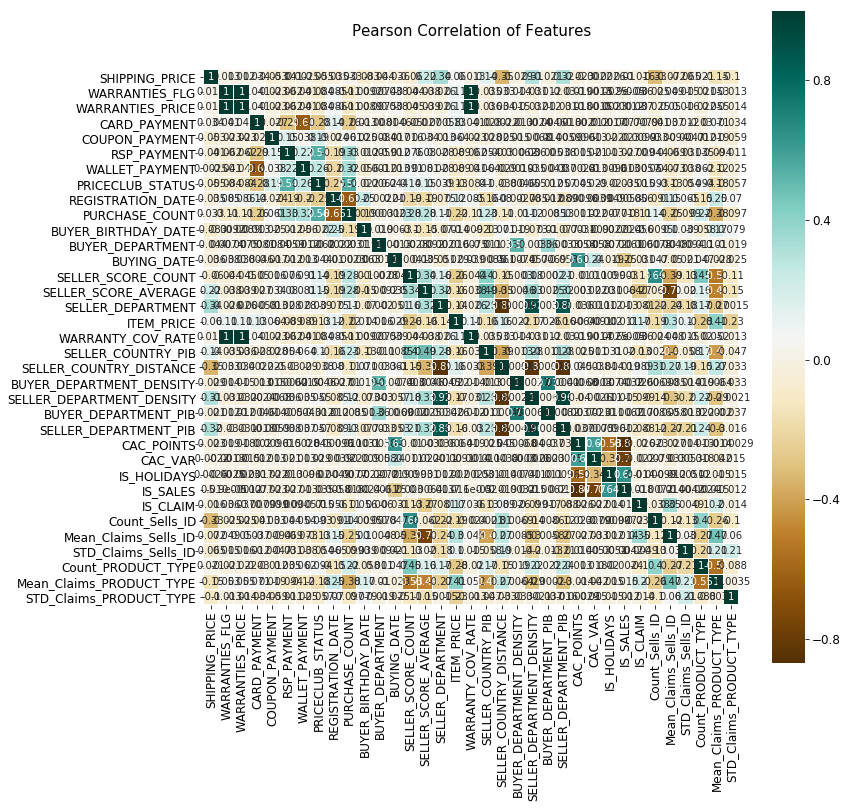

In [22]:
colormap = plt.cm.BrBG
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.select_dtypes(exclude="object").astype(float).corr(method='spearman'),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white',
            annot=True)

In [23]:
corr_mat = train_df.corr(method='spearman')

Là, je produis la liste des variables corrélées entre elles. Le seuil est inscrit à `0.6`, mais j'ai d'abord commencé à `0.9`, puis déscendu au fûr et à mesure

In [24]:
corr_level=0.6
for names in corr_mat.index:
    if len(corr_mat[(corr_mat.loc[names] > corr_level) & (corr_mat.loc[names].index != names)].index) > 0:
        print('column', names,' correlates with: ',corr_mat[(corr_mat.loc[names] > corr_level) & 
                                                                     (corr_mat.loc[names].index != names)].index)

column WARRANTIES_FLG  correlates with:  Index(['WARRANTIES_PRICE', 'WARRANTY_COV_RATE'], dtype='object')
column WARRANTIES_PRICE  correlates with:  Index(['WARRANTIES_FLG', 'WARRANTY_COV_RATE'], dtype='object')
column BUYING_DATE  correlates with:  Index(['CAC_POINTS'], dtype='object')
column SELLER_SCORE_COUNT  correlates with:  Index(['Count_Sells_ID'], dtype='object')
column SELLER_DEPARTMENT  correlates with:  Index(['SELLER_DEPARTMENT_DENSITY', 'SELLER_DEPARTMENT_PIB'], dtype='object')
column WARRANTY_COV_RATE  correlates with:  Index(['WARRANTIES_FLG', 'WARRANTIES_PRICE'], dtype='object')
column BUYER_DEPARTMENT_DENSITY  correlates with:  Index(['BUYER_DEPARTMENT_PIB'], dtype='object')
column SELLER_DEPARTMENT_DENSITY  correlates with:  Index(['SELLER_DEPARTMENT', 'SELLER_DEPARTMENT_PIB'], dtype='object')
column BUYER_DEPARTMENT_PIB  correlates with:  Index(['BUYER_DEPARTMENT_DENSITY'], dtype='object')
column SELLER_DEPARTMENT_PIB  correlates with:  Index(['SELLER_DEPARTMENT', '

In [25]:
list_to_drop=[
    "WARRANTIES_FLG",
    "WARRANTIES_PRICE",
    "SELLER_DEPARTMENT",
    "BUYER_DEPARTMENT",
    "Count_Sells_ID",
    "SELLER_ID",
    "IS_SALES"
]

train_df.drop(list_to_drop, axis=1, inplace=True)
train_df.drop("IS_CLAIM", axis=1, inplace=True)
test_df.drop(list_to_drop, axis=1, inplace=True)

On inscrit nos résultats

In [26]:
filename_train = DATA_PROCESSED+"/train.csv"
filename_test = DATA_PROCESSED+"/test.csv"

try:
    os.remove(filename_train)
    os.remove(filename_test)
except:
    pass;

train_df.to_csv(filename_train, index=False, sep=";")
test_df.to_csv(filename_test, index=False, sep=";")